In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#from swarm_sim import *

#Données

In [ ]:
MIN_PORTE = 20000 # porté minimale
MID_PORTE = 40000 # porté intermedière
MAX_PORTE = 60000 # porté maximale
DURATION = 10000 # Nombre d'échantillons temporels à analyser

# lire les données

In [ ]:
#df1 = pd.read_csv("https://docs.google.com/spreadsheets/d/1oLs-TPRG2JGFkdO_N2IMX3yLbjdu0xvZs3SlzRP_DPk/gviz/tq?tqx=out:csv&sheet=sample_1", sep=',', header=0)
df1 = pd.read_csv("Traces.csv", sep=',', header=0)

# translater les lignes

In [ ]:
df1.loc[-1] = df1.columns
df1.index = df1.index + 1  # shifting index
df1 = df1.sort_index()
df1.columns = list(range(len(df1.columns)))

# Enregistrer les satellites dans un dictionnaire, key=id, value=dataframe contenant les cordonnées du satellite à chaque instant

In [ ]:
satellites = {}
iter_max = 100
with tqdm(total = iter_max, desc = 'Data loading') as pbar:
    for i in range(iter_max):
        df = df1[i*3:i*3+3]
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1) # Fonction de mise à jour de la progression

Data loading:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-15-aae9c547e8d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coords'] = ['x','y','z']
<ipython-input-15-aae9c547e8d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coords'] = ['x','y','z']
Data loading:   2%|▏         | 2/100 [00:00<00:07, 13.87it/s]<ipython-input-15-aae9c547e8d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

# Initialiser les Swarms

In [ ]:
# dictionnaire des swarms
dict_swarm = {}

with tqdm(total=DURATION, desc='Converting to Swarm') as pbar:
    for t in range(DURATION):
        dict_swarm[t] = Swarm(
            connection_range=MAX_PORTE,
            nodes=[Node(id, node[t].x, node[t].y, node[t].z) for id,node in satellites.items()]
        )
        pbar.update(1)

Converting to Swarm: 100%|██████████| 10000/10000 [01:56<00:00, 85.54it/s]


# ajouter les voisins

In [ ]:
with tqdm(total=DURATION, desc='Neighbor matrix') as pbar:
    for t in range(DURATION):
        neighbor_matrix = dict_swarm[t].neighbor_matrix()
        for i,c in enumerate(neighbor_matrix):
            for j,k in enumerate(c):
                if k == 1:
                    dict_swarm[t].nodes[i].add_neighbor(dict_swarm[t].nodes[j])
        pbar.update(1)

Neighbor matrix: 100%|██████████| 10000/10000 [02:36<00:00, 63.90it/s]


# fonctions

In [ ]:
def vicinity2(swarm):
  nodes = swarm.nodes
  vicinity2_dict = []
  for i, node in enumerate(nodes):
    vicinity2_dict.append(node.k_vicinity(depth = 2))
  return vicinity2_dict

def vicinity3(swarm):
  nodes = swarm.nodes
  vicinity3_dict = []
  for i, node in enumerate(nodes):
    vicinity3_dict.append(node.k_vicinity(depth = 3))
  return vicinity3_dict

def degre(swarm):
  nodes = swarm.nodes
  degre_nodes = []
  for i, node in enumerate(nodes):
    degre_nodes.append(node.degree())
  return degre_nodes

def coefficient_clus(swarm):
    nodes = swarm.nodes
    degre_nodes = []
    for i, node in enumerate(nodes):
      degre_nodes.append(node.cluster_coef())
    return degre_nodes

def get_k_max(metric, swarms, k=1):
    if metric == "degre":
        list_values = np.mean([np.array(degre(swarm)) for swarm in swarms], axis=0)
    elif metric == "vicinity2":
        list_values = np.mean([np.array(vicinity2(swarm)) for swarm in swarms], axis=0)
    elif metric == "vicnity3":
        list_values = np.mean([np.array(vicinity3(swarm)) for swarm in swarms], axis=0)
    elif metric == "coefficient_clus":
        list_values = np.mean([np.array(coefficient_clus(swarm)) for swarm in swarms], axis=0)

    elif metric == "metrique_n":
        list_values = np.mean([np.array([node.metrique_n() for node in swarm.nodes]) for swarm in swarms], axis=0)

    # Récupération des indices des k éléments
    indices = np.argsort(-list_values)[:k]
    #indices = [swarms.keys()[i] for i in indices]
    if k == 1:
      return indices[0]
    return indices


def get_swarm_clus(swarms):
    return np.mean([swarm.cluster_coef() for swarm in swarms])

def get_degree(swarms):
    return np.mean([np.mean(swarm.degree()) for swarm in swarms])

def get_num_cc(swarms):
    return np.mean([len(swarm.connected_components()) for swarm in swarms])

def get_spaths_len(swarms):
    return np.mean([np.mean(swarm.shortest_paths_lengths(swarm)) for swarm in swarms])

def get_metric_n(swarms):
    return np.mean([np.mean([node.metrique_n() for node in swarm.nodes]) for swarm in swarms])

In [ ]:
get_k_max("degre",dict_swarm.values(), 4)

array([33, 42, 97,  5])

In [ ]:
import copy, random
def remove_nodes(indices, swarms):
    for swarm in swarms:
      for indice in indices:
        swarm.remove_node(swarm.get_node_by_id(indice))
    return swarms



# simulation

In [ ]:
valeurs_k = [0,5,10,15,20]
swarms = list(dict_swarm.values())
swarms_copy = copy.deepcopy(swarms)
coef_clust = [get_degree(swarms_copy)] #get_swarm_clus(swarms)

metrics_coef_clust = {"degre" : [], "vicinity2" : [], "vicinity3" : [], "coefficient_clus" : []}
indices = get_k_max("degre", swarms, k=20)
print("indices ", indices)
for k in valeurs_k[1:]:
    swarms_copy = remove_nodes(indices[k-5:k], swarms_copy)
    coef_clust.append(get_degree(swarms_copy))

"""
valeurs_k = [0,5,10,15,20]
swarms = list(dict_swarm.values())
swarms_copy = copy.deepcopy(swarms)
metrics_coef_clust = {"degre" : [], "vicinity2" : [], "vicinity3" : [], "coefficient_clus" : []}

for metric in metrics_coef_clust:
    indices = get_k_max(metric, swarms, k=20)
    swarms_copy = copy.deepcopy(swarms)
    metrics_coef_clust[metric].append(get_degree(swarms_copy))
    for k in valeurs_k[1:]:
          swarms_copy = remove_nodes(indices[k-5:k], swarms_copy)
          metrics_coef_clust[metric].append(get_degree(swarms_copy))
    plt.plot(valeurs_k, metrics_coef_clust[metric], label = metric)
plt.legend()
"""

indices  [33 42 97  5 27 71 78 87 80 90 73 84  7 52 18 51 50 30  9 39]
indices i  [33 42 97  5 27]
100
indices i  [71 78 87 80 90]
95
indices i  [73 84  7 52 18]
90
indices i  [51 50 30  9 39]
85


'\nfor metric in metrics_coef_clust:\n    new_swarms = remove_k_best(k, swarms, metric)\n    metrics_coef_clust[metric].append(get_swarm_clus(new_swarms))\n    \n'

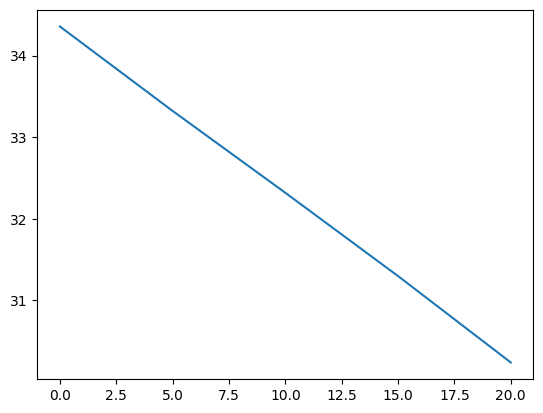

In [ ]:
"""
for metric in metrics_coef_clust:
    plt.plot(valeurs_k, metrics_coef_clust[metric], label = metric)
"""
plt.plot(valeurs_k, coef_clust, label = "degre")

In [ ]:
coef_clust

[34.35679999999999,
 33.32158315789474,
 32.31809666666667,
 31.297070588235297,
 30.238046249999996]

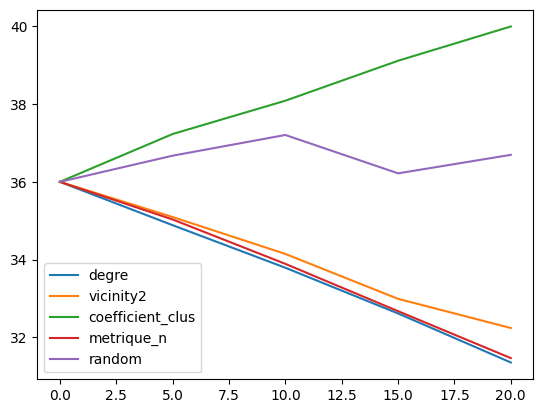

In [ ]:
valeurs_k = [0,5,10,15,20]
swarms = list(dict_swarm.values())[:2]
metrics_coef_clust = {"degre" : [], "vicinity2" : [], "coefficient_clus" : [],"metrique_n":[]}

for metric in metrics_coef_clust:
    indices = get_k_max(metric, swarms, k=20)
    swarms_copy = copy.deepcopy(swarms)
    metrics_coef_clust[metric].append(get_degree(swarms_copy))
    for k in valeurs_k[1:]:
          swarms_copy = remove_nodes(indices[k-5:k], swarms_copy)
          metrics_coef_clust[metric].append(get_degree(swarms_copy))
    plt.plot(valeurs_k, metrics_coef_clust[metric], label = metric)

swarms_copy = copy.deepcopy(swarms)
random_stats = [get_degree(swarms_copy)]

for k in valeurs_k[1:]:
      indices = random.sample(range(100), k)
      swarms_copy = remove_nodes(indices, swarms_copy)
      random_stats.append(get_degree(swarms_copy))
plt.plot(valeurs_k, random_stats, label = "random")

plt.legend()

In [ ]:

valeurs_k = [0,5,10,15,20]
swarms = list(dict_swarm.values())
metrics_coef_clust = {"degre" : [], "vicinity2" : [], "coefficient_clus" : []}

for metric in metrics_coef_clust:
    indices = get_k_max(metric, swarms, k=20)
    swarms_copy = copy.deepcopy(swarms)
    metrics_coef_clust[metric].append(get_spaths_len(swarms_copy))
    for k in valeurs_k[1:]:
          swarms_copy = remove_nodes(indices[k-5:k], swarms_copy)
          metrics_coef_clust[metric].append(get_spaths_len(swarms_copy))
    plt.plot(valeurs_k, metrics_coef_clust[metric], label = metric)
    break

swarms_copy = copy.deepcopy(swarms)
random_stats = [get_spaths_len(swarms_copy)]

for k in valeurs_k[1:]:
      indices = random.sample(range(100), k)
      swarms_copy = remove_nodes(indices, swarms_copy)
      random_stats.append(get_spaths_len(swarms_copy))
plt.plot(valeurs_k, random_stats, label = "random")

plt.legend()

KeyboardInterrupt: ignored

In [ ]:
import time
import threading
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from numpy.random import binomial
import math
from mpl_toolkits import mplot3d
from random import seed, choice, sample


#==============================================================================================

class Node:
    """
    Node class, representing a satellite in the swarm.
    """

    def __init__(self, id, x=0.0, y=0.0, z=0.0):
        """
        Node object constructor

        Args:
            id (int): the ID number of the satellite (mandatory)
            x (float, optional): the x-coordinate of the satellite. Defaults to 0.0.
            y (float, optional): the y-coordinate of the satellite. Defaults to 0.0.
            z (float, optional): the z-coordinate of the satellite. Defaults to 0.0.
        """
        self.id = int(id)
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        self.neighbors = [] # List(Node), list of neighbor nodes to the node
        self.group = -1 # Group ID to which belongs the node
        self.MessagesID = []

    def __str__(self):
        """
        Node object descriptor

        Returns:
            str: a string description of the node
        """
        nb_neigh = len(self.neighbors)
        return f"Node ID {self.id} ({self.x},{self.y},{self.z}) has {nb_neigh} neighbor(s)\tGroup: {self.group}"

    #*************** Common operations ****************
    def add_neighbor(self, node):
        """
        Function to add a node to the neighbor list of the node unless it is already in its list.

        Args:
            node (Node): the node to add.
        """
        if node not in self.neighbors:
            self.neighbors.append(node)

    def compute_dist(self, node):
        """
        Function to compute the Euclidean distance between two nodes.

        Args:
            node (Node): the node to compute the distance with.

        Returns:
            float: the Euclidean distance between the two nodes.
        """
        return math.dist((self.x, self.y, self.z) , (node.x, node.y, node.z))

    def is_neighbor(self, node, connection_range=0):
        """
        Function to verify whether two nodes are neighbors or not, based on the connection range.
        Either adds or removes the second node from the neighbor list of the first.

        Args:
            node (Node): the second node to analyse.
            connection_range (int, optional): the maximum distance between two nodes to establish a connection. Defaults to 0.

        Returns:
            int: 1 if neighbors, 0 if not.
        """
        if node.id != self.id:
            if self.compute_dist(node) <= connection_range:
                self.add_neighbor(node)
                return 1
            self.remove_neighbor(node)
        return 0

    def remove_neighbor(self, node):
        """
        Function to remove a node from the neighbor list of the node unless it is not in its list.

        Args:
            node (Node): the node to remove
        """
        if node in self.neighbors:
            self.neighbors.remove(node)

    def set_group(self, c):
        """
        Function to appoint a group ID to the node.

        Args:
            c (int): group ID.
        """
        self.group = c


    #*********** Metrics ***************
    def cluster_coef(self):
        """
        Function to compute the clustering coefficient of a node, which is defined as
        the existing number of edges between the neighbors of a node divided by the maximum
        possible number of such edges.

        Returns:
            float: the clustering coefficient of the node between 0 and 1.
        """
        dv = self.degree()
        max_edges = dv*(dv-1)/2
        if max_edges == 0:
            return 0
        edges = 0
        for v in self.neighbors:
            common_elem = set(v.neighbors).intersection(self.neighbors)
            edges += len(common_elem)
        return edges/(2*max_edges) # Divide by 2 because each edge is counted twice

    def degree(self):
        """
        Function to compute the degree (aka the number of neighbors) of the node. The neighbor lists must be established before running
        this function.

        Returns:
            int: the length of the neighbor list of the node.
        """
        return len(self.neighbors)

    def getNeighborsId(self):
        neighborsId = []
        for f in self.neighbors:
            neighborsId.append(f.id)
        return neighborsId

    def k_vicinity(self, depth=1):
        """
        Function to compute the k-vicinity (aka the extended neighborhood) of the node.
        The k-vicinity corresponds to the number of direct and undirect neighbors within at most k hops from the node.

        Args:
            depth (int, optional): the number of hops for extension. Defaults to 1.

        Returns:
            int: the length of the extended neighbor list of the node.
        """
        kv = self.neighbors.copy()
        for i in range(depth-1):
            nodes = kv
            kv.extend([n for node in nodes for n in node.neighbors])
        return len(set(kv))


    #*************** Sampling algorithms ****************
    def proba_walk(self, p:float, s=1, overlap=False):
        """
        Function to perform a probabilistic hop from the node to its neighbor(s), usually used with the Forest Fire algorithm (see Swarm object).
        Each neighbor node has a probability p to be chosen for the next hop.

        Args:
            p (float): the success probability between 0 and 1.
            s (int, optional): the random seed. Defaults to 1.
            overlap (bool, optional): if True, node groups are allowed to overlap. Defaults to False.

        Returns:
            list(Node): the list of neighbor nodes selected as next hops.
        """
        seed(s)
        search_list = self.neighbors
        if not overlap: # Restrain the search list to unassigned nodes
            search_list = [n for n in self.neighbors if n.group==-1]
        trial = binomial(1, p, len(search_list))
        nodes = [n for i,n in enumerate(search_list) if trial[i]==1] # Select the nodes that obtained a success above
        return nodes

    def random_group(self, clist, s=1):
        """
        Function to appoint a group ID chosen randomly from the input list.

        Args:
            clist (list(int)): the list of group IDs.
            s (int, optional): the random seed. Defaults to 1.
        """
        seed(s)
        self.set_group(choice(clist))

    def random_walk(self, s=1, overlap=False):
        """
        Function to perform a random walk from the current node. One of its neighbor nodes is chosen randomly as the next hop.

        Args:
            s (int, optional): the random seed for the experiment. Defaults to 1.
            overlap (bool, optional): if True, node groups are allowed to overlap. Defaults to False.

        Returns:
            Node: the neighbor node selected as the next hop.
        """
        seed(s)
        search_list = self.neighbors
        if not overlap: # Restrain the search list to unassigned nodes
            search_list = [n for n in self.neighbors if n.group==-1]
        return choice(search_list)

    def get_neighbors(self):
        node_neighbors = []
        for n in self.neighbors:
            if n in swarm.nodes:
                node_neighbors.append(n)
        return node_neighbors

    #*************************************** Nouvelles fonctions
    # Définir notre propre métrique
    def metrique_n(self) :
        return (self.degree() + 2 * self.k_vicinity(2))/(self.cluster_coef() + 1)

    #Méthode qui donne le meilleur neighbor avec notre metrique avec exluded_nodes est les nodes qui ont déjà le message
    def get_best_metric_neighbour(self, exculded_nodes) :
        #"""
        m = 0
        i = 0

        list_neighbors = [n for n in self.neighbors]
        if exculded_nodes is not None:
            for n in exculded_nodes:
              if n in list_neighbors:
                list_neighbors.remove(n)

        for j, n in enumerate(list_neighbors) :
            m1 = n.metrique_n()
            if m1 > m:
                m = m1
                i = j
        return list_neighbors[i]

        #"""

        #vérifier les neighbors qui n'ont pas le message id_message et l'envoyer ce message
    def check_neighbors(self, id_message) :
        #time.sleep(5)

        for n in self.neighbors :
            if not ( id_message  in n.MessagesID):
                n.MessagesID.append(id_message)
                n.forward_message(id_message)



    # Transmettre le message venue de node_sender au meilleur node de metrqiue_n qui n'a pas encore le id_message
    def forward_message(self, id_message):
        nodes_with_message = []
        for node in self.neighbors :
            if id_message in node.MessagesID :
                nodes_with_message.append(node)

        if len(nodes_with_message) == len(self.neighbors):
          return 0
        best_node = self.get_best_metric_neighbour(nodes_with_message)

        messageIds = best_node.MessagesID
        if not (id_message in messageIds):
            messageIds.append(id_message)

        x = threading.Thread(target=self.check_neighbors, args=(id_message,))
        x.start()
        best_node.forward_message(id_message)


     #envoyer en premier temps le message au meilleur node de metrique_n et attendre 10s et on check_neighbors
    def send_message(self, id_message) :
        self.MessagesID.append(id_message)
        best_node = self.get_best_metric_neighbour([])
        best_node.MessagesID.append(id_message)
        #Créer deux thread en meme temps pour forwarder le message au meilleur neighbor et check_neighbors après 10s
        x = threading.Thread(target=self.check_neighbors, args=(id_message,))
        x.start()

        best_node.forward_message(id_message)


    #***************************************


#==============================================================================================

class Swarm:
    """
    Swarm object, representing a swarm of nanosatellites.
    """

    def __init__(self, connection_range=0, nodes=[]):
        """
        Swarm object constructor

        Args:
            connection_range (int, optional): the maximum distance between two nodes to establish a connection. Defaults to 0.
            nodes (list, optional): list of Node objects within the swarm. Defaults to [].
        """
        self.connection_range = connection_range
        self.nodes = nodes

    def __str__(self):
        """
        Swarm object descriptor

        Returns:
            str: the string description of the swarm
        """
        nb_nodes = len(self.nodes)
        return f"Swarm of {nb_nodes} node(s), connection range: {self.connection_range}"

    #*************** Common operations ***************
    def add_node(self, node:Node):
        """
        Function to add a node to the swarm unless it is already in.

        Args:
            node (Node): the node to add.
        """
        if node not in self.nodes:
            self.nodes.append(node)

    def distance_matrix(self):
        """
        Function to compute the Euclidean distance matrix of the swarm.

        Returns:
            list(list(float)): the 2-dimensional distance matrix formatted as matrix[node1][node2] = distance.
        """
        matrix = []
        for n1 in self.nodes:
            matrix.append([n1.compute_dist(n2) for n2 in self.nodes if n1.id != n2.id])
        return matrix

    def get_node_by_id(self, id:int):
        """
        Function to retrieve a Node object in the swarm from its node ID.

        Args:
            id (int): the ID of the node.

        Returns:
            Node: the Node object with the corresponding ID.
        """
        for node in self.nodes:
            if node.id == id:
                return node

    def neighbor_matrix(self, connection_range=None):
        """
        Function to compute the neighbor matrix of the swarm.
        If two nodes are neighbors (according to the given connection range), the row[col] equals to 1. Else 0.

        Args:
            connection_range (int, optional): the connection range of the swarm. Defaults to None.

        Returns:
            list(list(int)): the 2-dimensional neighbor matrix formatted as matrix[node1][node2] = neighbor.
        """
        matrix = []
        if not connection_range:
            connection_range=self.connection_range # Use the attribute of the Swarm object if none specified
        for node in self.nodes:
            matrix.append([node.is_neighbor(nb,connection_range) for nb in self.nodes])
        return matrix

    def remove_node(self, node:Node):
        """
        Function to remove a node from the swarm unless it is already out.

        Args:
            node (Node): the node to remove.
        """
        if node in self.nodes:
            self.nodes.remove(node)

    def reset_connection(self):
        """
        Function to empty the neighbor list of each node of the swarm.
        """
        for node in self.nodes:
            node.neighbors = []

    def reset_groups(self):
        """
        Function to reset the group ID to -1 for each node of the swarm.
        """
        for node in self.nodes:
            node.set_group(-1)

    def swarm_to_nxgraph(self):
        """
        Function to convert a Swarm object into a NetworkX Graph. See help(networkx.Graph) for more information.

        Returns:
            nx.Graph: the converted graph.
        """
        G = nx.Graph()
        G.add_nodes_from([n.id for n in self.nodes])
        for ni in self.nodes:
            for nj in self.nodes:
                if ni.is_neighbor(nj, self.connection_range)==1:
                    G.add_edge(ni.id,nj.id)
        return G


    #*************** Metrics ******************
    def cluster_coef(self):
        """
        Function to compute the clustering coefficients distribution of the swarm.
        The clustering coefficient is defined as the existing number of edges between the neighbors of a node divided by the maximum
        possible number of such edges.

        Returns:
            list(float): list of clustering coefficients between 0 and 1.
        """
        return [node.cluster_coef() for node in self.nodes]

    def connected_components(self):
        """
        Function to define the connected components in the network.

        Returns:
            list(list(int)): nested list of node IDs for each connected component.
        """
        visited = {}
        for node in self.nodes: # Initialize all nodes as unvisited
            visited[node.id] = False
        cc = []
        for node in self.nodes:
            if visited[node.id]==False: # Perform DFS on each unvisited node
                temp = []
                cc.append(self.DFSUtil(temp, node, visited))
        return cc

    def degree(self):
        """
        Function to compute the degree (aka the number of neighbors) of each node within the swarm.

        Returns:
            list(int): the list of node degrees.
        """
        return [node.degree() for node in self.nodes]

    def DFSUtil(self, temp, node, visited):
        """
        Function to perform a Depth-First Search on the graph. Usually used to define all connected components in the swarm.

        Args:
            temp (list(int)): the list of visited node IDs so far.
            node (Node): the node to be analysed.
            visited (dict(int:bool)): the dictionary of matches between the node ID and its state (visited or not).

        Returns:
            list(int): the updated temp list.
        """
        visited[node.id] = True # Mark the current node as visited
        temp.append(node.id) # Store the vertex to list
        for n in node.neighbors:
            if n in self.nodes:
                if visited[n.id] == False: # Perform DFS on unvisited nodes
                    temp = self.DFSUtil(temp, n, visited)
        return temp

    def diameter(self, group):
        """
        Function to compute the diameter of the swarm. The swarm is first converted into a nx.Graph object (see help(Swarm.swarm_to_nxgraph)).
        The diameter of the swarm is defined as the maximum shortest path distance between all pairs of nodes, in terms of number of hops.

        Args:
            group (Swarm): the list of nodes to take into account.

        Returns:
            tuple: the diameter of the swarm as (source_id, target_id, diameter).
        """
        G = self.swarm_to_nxgraph()
        node_ids = [n.id for n in group.nodes]
        max_length = (0,0,0) # Source, target, number of hops
        for ni in node_ids:
            for nj in node_ids:
                if nx.has_path(G, ni, nj):
                    sp = nx.shortest_path(G, ni, nj)
                    if len(sp)-1 > max_length[2]:
                        max_length = (ni, nj, len(sp)-1)
        return max_length

    def graph_density(self):
        """
        Function to compute the graph density of the swarm. The graph density is defined as the ratio between the number of edges and the maximum
        possible number of such edges.
        Let N be the number of nodes in the swarm. Then the maximum number of edges max_edges = N*(N-1)/2.
        Let m be the number of existing edges in the swarm. Then the graph density GD = (2*m)/(N*(N-1)).

        Returns:
            float: the graph density between 0 and 1.
        """
        N = len(self.nodes)
        max_edges = N*(N-1)/2
        if max_edges == 0:
            return 0
        edges = 0
        for n in self.nodes:
            common_nodes = set(n.neighbors).intersection(self.nodes)
            edges += len(common_nodes)
        return edges/(2*max_edges) # Divide by 2 because each edge is counted twice

    def k_vicinity(self, depth=1):
        """
        Function to compute the k-vicinity (aka the extended neighborhood) of each node in the swarm.
        The k-vicinity corresponds to the number of direct and undirect neighbors within at most k hops from the node.

        Args:
            depth (int, optional): the number of hops for extension. Defaults to 1.

        Returns:
            list(int): list of k-vicinity values for each node.
        """
        return [node.k_vicinity(depth) for node in self.nodes]

    def shortest_paths_lengths(self, group):
        """
        Function to compute all the shortest paths between each pair of nodes (Dijkstra algorithm) and return their length. The swarm is
        first converted into a nx.Graph object (see help(Swarm.swarm_to_nxgraph)).

        Args:
            group (Swarm): the list of nodes to take into account.

        Returns:
            list(int): the list of the shortest path lengths.
        """
        G = self.swarm_to_nxgraph()
        node_ids = [n.id for n in group.nodes]
        lengths = []
        for ni in node_ids:
            lengths.append([])
            for nj in node_ids:
                if nx.has_path(G, ni, nj) and nj != ni:
                    lengths[ni-1].append(nx.shortest_path_length(G, source=ni, target=nj))
                else :
                    lengths[ni-1].append(0)
        return lengths

    def shortest_path_prompt(self, group):
        """
        Function to compute the shortest path between two nodes in the swarm. The swarm is first converted into a nx.Graph object
        (see help(Swarm.swarm_to_nxgraph)).

        Args:
            group (Swarm): the list of nodes to take into account.

        Returns:
            tuple: the shortest path between two nodes as (source_id, target_id, shortest_path).
        """
        G = self.swarm_to_nxgraph()
        node_ids = [n.id for n in group.nodes]
        lengths = []
        for ni in node_ids:
            lengths.append([])
            for nj in node_ids:
                if nx.has_path(G, ni, nj) and nj != ni:
                    lengths[ni-1].append(nx.bidirectional_shortest_path(G, source=ni, target=nj))
                else :
                    lengths[ni-1].append("Ø")
        return lengths

    def number_of_shortest_path_through_node(self):
        """
        Function to compute the shortest path between two nodes in the swarm. The swarm is first converted into a nx.Graph object
        (see help(Swarm.swarm_to_nxgraph)).

        Args:
            group (Swarm): the list of nodes to take into account.

        Returns:
            tuple: the shortest path between two nodes as (source_id, target_id, shortest_path).
        """
        G = self.swarm_to_nxgraph()
        all_pairs_shortest_path = nx.all_pairs_shortest_path(G)
        return all_pairs_shortest_path


    #************** Sampling algorithms ****************
    def ForestFire(self, n=10, p=0.7, s=1, overlap=False):
        """
        Function to perform graph sampling by the Forest Fire algorithm.
        In the initial phase, n nodes are selected as "fire sources". Then, the fire spreads to the neighbors with a probability of p.
        We finally obtain n samples defined as the nodes burned by each source.

        Args:
            n (int, optional): the initial number of sources. Defaults to 10.
            p (float, optional): the fire spreading probability. Defaults to 0.7.
            s (int, optional): the random seed. Defaults to 1.
            overlap (bool, optional): if True, node groups are allowed to overlap. Defaults to False.

        Returns:
            dict(int:Swarm): the dictionary of group IDs and their corresponding Swarm sample.
        """
        sources = sample(self.nodes, n) # Initial random sources
        swarms = {} # Dict(group ID:Swarm)
        for i,src in enumerate(sources): # Initialize swarms
            src.set_group(i)
            swarms[i] = Swarm(self.connection_range, nodes=[src])
        free_nodes = [n for n in self.nodes if n.group==-1]
        burning_nodes = sources
        next_nodes = []
        while free_nodes: # Spread paths from each burning node in parallel
            for bn in burning_nodes:
                if not free_nodes:
                    break
                free_neighbors = set(free_nodes).intersection(bn.neighbors)
                if free_neighbors: # At least one unassigned neighbor
                    nodes = bn.proba_walk(p, i, overlap) # Next node(s)
                else:
                    nodes = [self.random_jump(s, overlap)] # If no neighbor, perform random jump in the graph
                for n in nodes:
                    n.set_group(bn.group)
                    swarms[bn.group].add_node(n)
                    free_nodes.remove(n)
                    next_nodes.append(n)
            burning_nodes = next_nodes
        return swarms

    def MDRW(self, n=10, s=1, overlap=False):
        """
        Function to perform graph sampling by the Multi-Dimensional Random Walk algorithm.
        In the initial phase, n nodes are selected as sources. Then they all perform random walks in parallel (see help(Node.random_walk) for
        more information).
        We finally obtain n samples defined as the random walks from each source.

        Args:
            n (int, optional): the initial number of sources. Defaults to 10.
            s (int, optional): the random seed. Defaults to 1.
            overlap (bool, optional): if True, node groups are allowed to overlap. Defaults to False.

        Returns:
            dict(int:Swarm): the dictionary of group IDs and their corresponding Swarm sample.
        """
        sources = sample(self.nodes, n) # Initial random sources
        swarms = {} # Dict(group ID:Swarm)
        for i,src in enumerate(sources): # Initialize swarms
            src.set_group(i)
            swarms[i] = Swarm(self.connection_range, nodes=[src])
        free_nodes = [n for n in self.nodes if n.group==-1]
        while free_nodes: # Spread paths to desired length
            for k in swarms.keys():
                n_i = swarms[k].nodes[-1] # Current node
                free_neighbors = set(free_nodes).intersection(n_i.neighbors)
                if free_neighbors: # At least one unassigned neighbor
                    n_j = n_i.random_walk(i, overlap) # Next node
                else:
                    n_j = self.random_jump(s, overlap) # If no neighbor, perform random jump in the graph
                n_j.set_group(n_i.group)
                swarms[k].add_node(n_j)
                free_nodes.remove(n_j)
        return swarms

    def RNS(self, clist=range(10), s=1):
        """
        Function to perform graph sampling by the Random Node Sampling algorithm.
        Each node choses a random group ID from the list given as parameter.

        Args:
            clist (list(int)): list of group IDs. Defaults to range(10).
            s (int, optional): random seed. Defaults to 1.

        Returns:
            dict(int:Swarm): the dictionary of group IDs and their corresponding Swarm sample.
        """
        swarms = {}
        for i, node in enumerate(self.nodes):
            node.random_group(clist, s*i)
        for i in clist: # Separate into swarms
            swarms[i] = Swarm(self.connection_range,
                                nodes=[n for n in self.nodes if n.group==i])
        return swarms

    def random_jump(self, s=1, overlap=False):
        """
        Function to choose a new node in the graph by performing a random jump.

        Args:
            s (int, optional): the random seed. Defaults to 1.
            overlap (bool, optional): if True, node groups are allowed to overlap. Defaults to False.

        Returns:
            Node: the randomly chosen node.
        """
        seed(s)
        search_list = self.nodes
        if not overlap: # Restrain the search list to unassigned nodes
            search_list = [n for n in self.nodes if n.group==-1]
        return choice(search_list)


    #************** Plot functions **************
    def plot_nodes(self, n_color='blue'):
        """
        Function to create a 3D-plot of the swarm at a given timestamp.

        Args:
            n_color (str, optional) : Nodes color. Defaults to 'blue'.
        """
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        x_data = [node.x for node in self.nodes]
        y_data = [node.y for node in self.nodes]
        z_data = [node.z for node in self.nodes]
        ax.scatter(x_data, y_data, z_data, c=n_color, s=50)
        ax.plot([0,0],[0, 0],[0, 0], c='red', markersize=50000) # Origin
        plt.show()

    def plot_nodes(self,n_color="blue",nodes = []):
        print("Please agree that this function is very experimental and must not be executed before understanding it's limitations")
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        x_data_genuine = [node.x for node in self.nodes]
        y_data_genuine = [node.y for node in self.nodes]
        z_data_genuine = [node.z for node in self.nodes]
        mod_x = [node.x for node in nodes]
        mod_y = [node.y for node in nodes]
        mod_z = [node.z for node in nodes]
        ax.scatter(x_data_genuine, y_data_genuine, z_data_genuine, c=n_color, s=50)
        # Plot the removed nodes with short comparison of nodes values
        # Data are supposedly following the rule of two satellites with the same coords
        # are in fact quantically intricated
        # See bra-ket notation |sat⟩ = sat1|cord⟩ + sat2|cord⟩ for futher informations
        ax.scatter([x for x in mod_x if x not in x_data_genuine ], [y for y in mod_y if y not in y_data_genuine ], [z for z in mod_z if z not in z_data_genuine ], color="red", s=50)
        ax.plot([0,0],[0, 0],[0, 0], color='red', markersize=50000) # Origin
        plt.show()

    def plot_edges(self, n_color='blue', e_color='gray'):
        """
        Function to create a 3D-plot of the swarm connectivity at a given timestamp.

        Args:
            n_color (str, optional): Nodes color. Defaults to 'blue'.
            e_color (str, optional): Edges color. Defaults to 'gray'.

        """
        print("hello")
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        x_data = [node.x for node in self.nodes]
        y_data = [node.y for node in self.nodes]
        z_data = [node.z for node in self.nodes]
        ax.scatter(x_data, y_data, z_data, c=n_color, s=50)
        #ax.plot([0,0],[0, 0],[0, 0], color='red', markersize=50000) # Origin
        for node in self.nodes:
            for n in node.neighbors:
                if n in self.nodes:
                    ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], c=e_color)
        plt.show()


In [ ]:
satellites = {}
iter_max = 100
with tqdm(total = iter_max, desc = 'Data loading') as pbar:
    for i in range(iter_max):
        df = df1[i*3:i*3+3]
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1) # Fonction de mise à jour de la progression

Data loading:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-408-aae9c547e8d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coords'] = ['x','y','z']
<ipython-input-408-aae9c547e8d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coords'] = ['x','y','z']
Data loading:   2%|▏         | 2/100 [00:01<01:22,  1.19it/s]<ipython-input-408-aae9c547e8d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [ ]:
# dictionnaire des swarms
dict_swarm = {}

with tqdm(total=DURATION, desc='Converting to Swarm') as pbar:
        dict_swarm[0] = Swarm(
            connection_range=MAX_PORTE,
            nodes=[Node(id, node[0].x, node[0].y, node[0].z) for id,node in satellites.items()]
        )
        pbar.update(1)

Converting to Swarm:   0%|          | 1/10000 [00:00<1:00:20,  2.76it/s]


In [ ]:
with tqdm(total=DURATION, desc='Neighbor matrix') as pbar:
        neighbor_matrix = dict_swarm[0].neighbor_matrix()
        for i,c in enumerate(neighbor_matrix):
            for j,k in enumerate(c):
                if k == 1:
                    dict_swarm[0].nodes[i].add_neighbor(dict_swarm[0].nodes[j])
        pbar.update(1)

Neighbor matrix:   0%|          | 1/10000 [00:00<05:14, 31.75it/s]


In [ ]:
import copy
swarm = copy.deepcopy(dict_swarm[0])
x = []
for i in range(0):
    x.append(swarm.nodes.pop(-1))


for node in swarm.nodes:
    for n in x:
        node.remove_neighbor(n)

In [ ]:
def plot_swarm(swarm, nodes=[], new_node=None):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    bl_nodes = [node for node in swarm.nodes if (node not in nodes + [new_node])]
    x_data = [node.x for node in bl_nodes]
    y_data = [node.y for node in bl_nodes]
    z_data = [node.z for node in bl_nodes]
    ax.scatter(x_data, y_data, z_data, c='blue', s=50)

    x_data_n = [node.x for node in nodes]
    y_data_n = [node.y for node in nodes]
    z_data_n = [node.z for node in nodes]

    ax.scatter(x_data_n, y_data_n, z_data_n, c='green', s=50)

    if new_node:
        ax.scatter(new_node.x, new_node.y, new_node.z, c='red', s=50)
    #ax.plot([0,0],[0, 0],[0, 0], color='red', markersize=50) # Origin
    for node in swarm.nodes:
        for n in node.neighbors:
            if n in swarm.nodes:
                ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], c='gray')

33 sends to  71
71 sends to  27
27 sends to  78
78 sends to  17
17 sends to  97
97 sends to  5
5 sends to  84
84 sends to  90
90 sends to  50
50 sends to  70
70 sends to  42
42 sends to  40
40 sends to  80
80 sends to  24
24 sends to  11
11 sends to  75
75 sends to  57
57 sends to  55
55 sends to  41
41 sends to  7
7 sends to  19
19 sends to  58
58 sends to  73
73 sends to  87
87 sends to  22
22 sends to  94
94 sends to  64
64 sends to  67
67 sends to  31
31 sends to  52
52 sends to  2
2 sends to  51
51 sends to  81
81 sends to  48
48 sends to  25
25 sends to  0
0 sends to  63
63 sends to  23
23 sends to  18
18 sends to  6
6 sends to  72
72 sends to  1
1 sends to  74
74 sends to  68
68 sends to  14
14 sends to  30
30 sends to  45
45 sends to  21
21 sends to  95
95 sends to  38
38 sends to  44
44 sends to  29
29 sends to  35
35 sends to  96
96 sends to  20
20 sends to  46
46 sends to  28
28 sends to  36
36 sends to  79
79 sends to  61
61 sends to  99
99 sends to  16
16 sends to  49
49 s

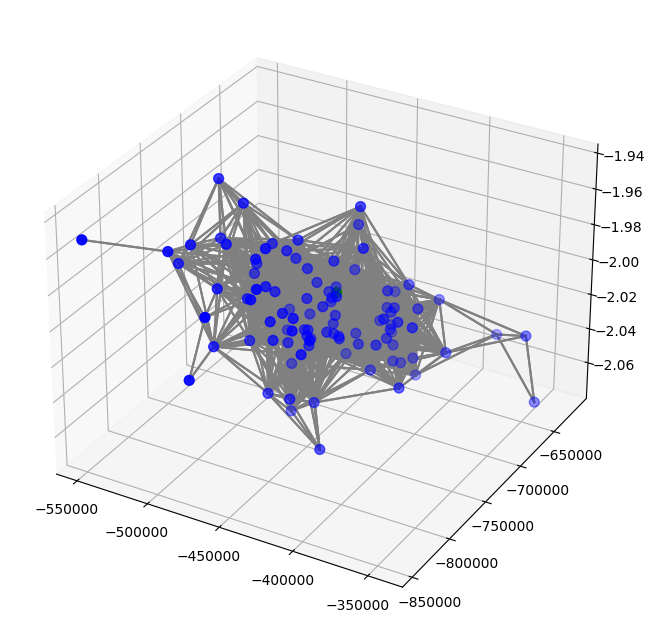

In [ ]:
node_sender = swarm.nodes[9]
list_nodes = [node_sender]
plot_swarm(swarm, nodes=list_nodes)
node_sender.send_message(1)




17 sends to  33
33 sends to  71
71 sends to  27
27 sends to  78
78 sends to  97
97 sends to  5
5 sends to  84
84 sends to  90
90 sends to  50
50 sends to  70
70 sends to  42
42 sends to  40
40 sends to  80
80 sends to  24
24 sends to  11
11 sends to  75
75 sends to  57
57 sends to  55
55 sends to  41
41 sends to  7
7 sends to  19
19 sends to  58
58 sends to  73
73 sends to  87
87 sends to  22
22 sends to  9
9 sends to  94
94 sends to  64
64 sends to  67
67 sends to  31
31 sends to  52
52 sends to  2
2 sends to  51
51 sends to  81
81 sends to  48
48 sends to  25
25 sends to  0
0 sends to  63
63 sends to  23
23 sends to  18
18 sends to  6
6 sends to  72
72 sends to  1
1 sends to  74
74 sends to  68
68 sends to  14
14 sends to  30
30 sends to  45
45 sends to  21
21 sends to  95
95 sends to  38
38 sends to  44
44 sends to  29
29 sends to  35
35 sends to  96
96 sends to  20
20 sends to  46
46 sends to  28
28 sends to  36
36 sends to  79
79 sends to  61
61 sends to  99
99 sends to  16
16 sen

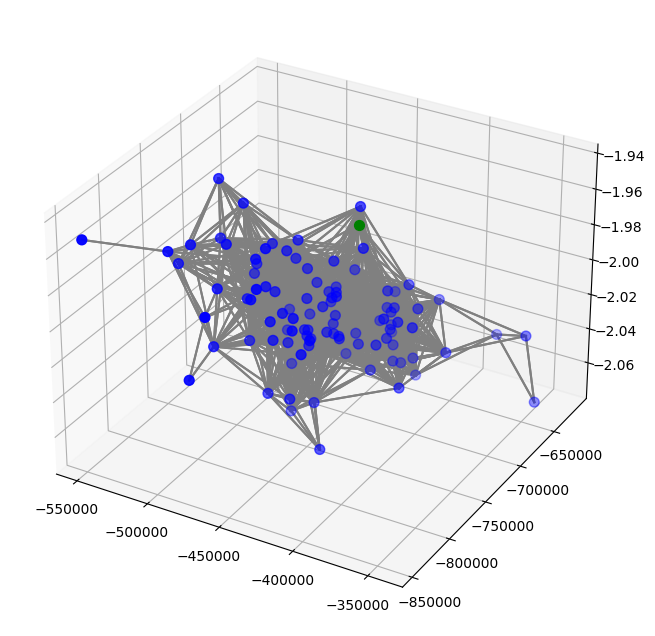

In [ ]:
node_sender = swarm.nodes[4]
list_nodes = [node_sender]
plot_swarm(swarm, nodes=list_nodes)
node_sender.send_message(4)


In [ ]:
node_sender.neighbors[0].id, node_sender.neighbors[1].id, node_sender.neighbors[2].id, node_sender.neighbors[3].id


(7, 8, 9, 14)

In [ ]:
for neighbor in swarm.get_node_by_id(9).neighbors:
    if neighbor != node_sender:
        print(neighbor.MessagesID)


[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[]
[1, 4]
[1, 4]
[]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[]
[1, 4]
[1, 4]
[]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]
[1, 4]


In [ ]:
for node in swarm.nodes :
  print(node.id, " :", node.MessagesID)

0  : [1, 4]
1  : [1, 4]
2  : [1, 4]
3  : []
4  : [4]
5  : [1, 4]
6  : [1, 4]
7  : [1, 4]
8  : []
9  : [1, 4]
10  : [1, 4]
11  : [1, 4]
12  : []
13  : [1, 4]
14  : [1, 4]
15  : []
16  : [1, 4]
17  : [1, 4]
18  : [1, 4]
19  : [1, 4]
20  : [1, 4]
21  : [1, 4]
22  : [1, 4]
23  : [1, 4]
24  : [1, 4]
25  : [1, 4]
26  : []
27  : [1, 4]
28  : [1, 4]
29  : [1, 4]
30  : [1, 4]
31  : [1, 4]
32  : []
33  : [1, 4]
34  : []
35  : [1, 4]
36  : [1, 4]
37  : []
38  : [1, 4]
39  : []
40  : [1, 4]
41  : [1, 4]
42  : [1, 4]
43  : []
44  : [1, 4]
45  : [1, 4]
46  : [1, 4]
47  : []
48  : [1, 4]
49  : [1, 4]
50  : [1, 4]
51  : [1, 4]
52  : [1, 4]
53  : [1, 4]
54  : []
55  : [1, 4]
56  : []
57  : [1, 4]
58  : [1, 4]
59  : [1, 4]
60  : []
61  : [1, 4]
62  : []
63  : [1, 4]
64  : [1, 4]
65  : []
66  : []
67  : [1, 4]
68  : [1, 4]
69  : []
70  : [1, 4]
71  : [1, 4]
72  : [1, 4]
73  : [1, 4]
74  : [1, 4]
75  : [1, 4]
76  : []
77  : []
78  : [1, 4]
79  : [1, 4]
80  : [1, 4]
81  : [1, 4]
82  : [1, 4]
83  : [1, 4]
8

In [ ]:
df1

NameError: ignored